In [1]:
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms, utils
import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np

In [2]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
BATCH_SIZE = 100

'''
Uncomment for MNIST

train_data = datasets.MNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST('./data', train=False,
                           transform=transforms.ToTensor())
'''

'''
Uncomment for FashionMNIST
'''

train_data = datasets.FashionMNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_data = datasets.FashionMNIST('./data', train=False,
                           transform=transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=BATCH_SIZE, shuffle=True)



cuda


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [31]:
import torch.nn as nn
import torch.nn.functional as F

class CondConvVAE(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.input_dim = 784
        self.latent_dim = 2
        self.latent_batch_size = 4
        self.input_batch_size = 1#BATCH_SIZE
        
        self.x_sigma = 1.5
        
        self.enc_conv1 = nn.Conv2d(1, 20, 15)
        self.enc_conv2 = nn.Conv2d(20, 40, 8)
        
        self.enc_lin1 = nn.Linear(10, 7)
        self.enc_lin2 = nn.Linear(7, 5)
        
        self.enc_mu = nn.Linear(7*7*40 + 5, self.latent_dim)
        self.enc_logvar = nn.Linear(7*7*40 + 5, self.latent_dim)
        
        self.dec_deconv1 = nn.Linear(self.latent_dim + 10, 7*7*40)
        self.dec_deconv2 = nn.ConvTranspose2d(40, 20, 8)
        self.dec_deconv3 = nn.ConvTranspose2d(20, 1, 15)
        
        self.sigm = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0)
    def decoder(self, z, c):
        input = torch.cat((z,c), 1)
        dec_out1 = self.dropout(F.relu(self.dec_deconv1(input)))
        dec_out1 = dec_out1.view(dec_out1.shape[0], 40, 7, 7)
        dec_out2 = self.dropout(F.relu(self.dec_deconv2(dec_out1)))
        dec_out = self.sigm(self.dec_deconv3(dec_out2))
        return dec_out
        
    def encoder(self, x, c):
        enc_out1 = self.dropout(F.relu(self.enc_conv1(x)))
        enc_out2 = self.dropout(F.relu(self.enc_conv2(enc_out1)))
        enc_out2 = enc_out2.view(enc_out2.shape[0], -1)
        
        enc_lin_out1 = self.dropout(F.relu(self.enc_lin1(c)))
        enc_lin_out2 = self.dropout(F.relu(self.enc_lin2(enc_lin_out1)))

        enc_out2 = torch.cat((enc_out2, enc_lin_out2), 1)
        
        enc_out_mu = self.enc_mu(enc_out2)
        enc_out_logvar = self.enc_logvar(enc_out2)
        return enc_out_mu, enc_out_logvar
    
    def reparam_trick(self, mu_z, logvar_z):
        sigma_z = torch.exp(logvar_z)
        eps = torch.rand_like(sigma_z)
        return mu_z + eps*sigma_z
    
    def forward(self, x, c):
        #x = x.view(x.shape[0], -1)
        mu_x, logvar_x = self.encoder(x, c)
        z_batch = self.reparam_trick(mu_x, logvar_x)
        recon_x_batch = self.decoder(z_batch, c)
        return recon_x_batch, mu_x, logvar_x

    def loss_function(self, x, recon_x_batch, mu_x, logvar_x):
        x = x.view(x.shape[0], -1)
        recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
        kl_div = 0.5*torch.sum(mu_x.pow(2) + logvar_x.exp() - logvar_x - 1)/self.input_batch_size
        return recon_loss + kl_div
    


In [33]:
#Skip this block if you want to see the output alone using already trained weights

vae = CondConvVAE().to(device)
#optimizer = optim.SGD(vae.parameters(), lr=0.005, weight_decay=1e-5)
optimizer = optim.Adam(vae.parameters())

vae.train()

for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        labels = F.one_hot(labels, num_classes=10).to(device)
        labels = labels.type(torch.FloatTensor).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        recon_x, mu_x, logvar_x = vae(inputs, labels)
        loss = vae.loss_function(inputs, recon_x, mu_x, logvar_x)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 3365.109
[1,   400] loss: 2708.618
[1,   600] loss: 2616.555
[2,   200] loss: 2579.948
[2,   400] loss: 2568.089
[2,   600] loss: 2561.712
[3,   200] loss: 2545.978
[3,   400] loss: 2544.253
[3,   600] loss: 2538.848
[4,   200] loss: 2526.095
[4,   400] loss: 2538.366
[4,   600] loss: 2528.578
[5,   200] loss: 2520.224
[5,   400] loss: 2524.137
[5,   600] loss: 2521.913
[6,   200] loss: 2519.065
[6,   400] loss: 2516.027
[6,   600] loss: 2515.262
[7,   200] loss: 2516.024
[7,   400] loss: 2501.868
[7,   600] loss: 2515.988
[8,   200] loss: 2512.732
[8,   400] loss: 2512.573
[8,   600] loss: 2501.376
[9,   200] loss: 2504.255
[9,   400] loss: 2509.753
[9,   600] loss: 2499.349
[10,   200] loss: 2492.031
[10,   400] loss: 2509.306
[10,   600] loss: 2505.293
[11,   200] loss: 2498.819
[11,   400] loss: 2495.912
[11,   600] loss: 2503.670
[12,   200] loss: 2497.186
[12,   400] loss: 2497.134
[12,   600] loss: 2498.959
[13,   200] loss: 2507.314
[13,   400] loss: 2494.846
[

In [34]:
#Uncomment for MNIST weights
#PATH = './mnist_net_avg10_2.pth' 

#Uncomment for Fashion MNIST weights
PATH = './fmnist_net.pth'

#Uncomment to save after training
torch.save(vae.state_dict(), PATH)

vae_n = CondConvVAE()
vae_n.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

torch.Size([100])
torch.int64


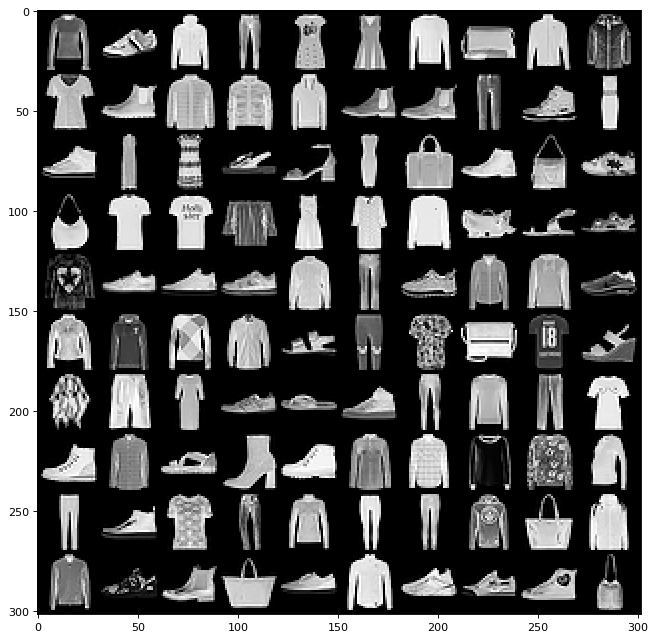

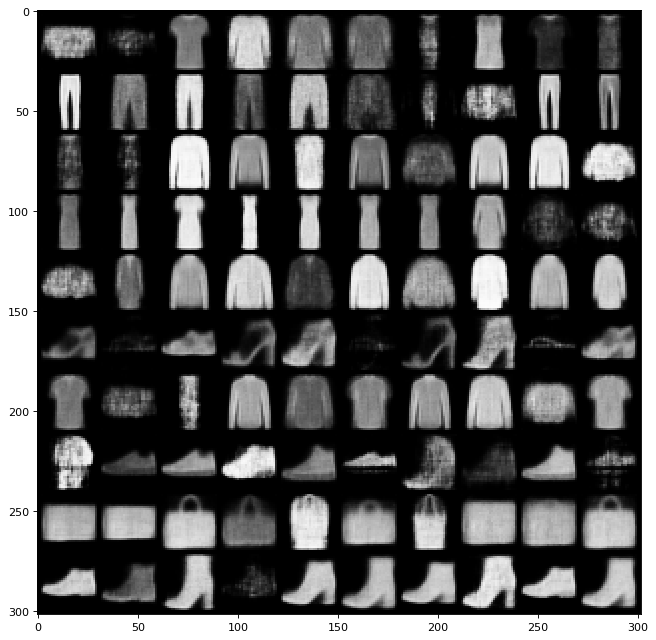

In [39]:
z = torch.randn((100,vae_n.latent_dim))
c = [int(i/10) for i in range(100)]
c = torch.Tensor(c)
c=c.type(torch.LongTensor)
print(c.shape)
print(c.dtype)
c = F.one_hot(c, num_classes=10)

from matplotlib.pyplot import figure

#Print 100 samples from the dataset
figure(figsize=(10, 10), dpi=80)
image_data, labels = next(iter(train_loader))
image_data = image_data[:,None,:]
image_data = torch.reshape(image_data,(100,1,28,28))
grid_image_data = utils.make_grid(image_data, nrow=10)
grid_image_data_np = grid_image_data.cpu().detach().numpy().transpose(1,2,0)
plt.imshow(grid_image_data_np)
#plt.savefig('mnist_data')
plt.show()

#Print 100 samples using the VAE
figure(figsize=(10, 10), dpi=80)
image_vae = vae_n.decoder(z,c)
image_vae = image_vae[:, None, :]
image_vae = torch.reshape(image_vae,(100,1,28,28))
grid_image_vae = utils.make_grid(image_vae, nrow=10)
grid_image_vae_np = grid_image_vae.cpu().detach().numpy().transpose(1,2,0)
plt.imshow(grid_image_vae_np)
#plt.savefig('mnist_vae')
plt.show()
